In [5]:
import pandas as pd
import geopandas as gpd
import rasterio
from openpyxl.styles.builtins import total
from rasterio.mask import mask
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from shapely.geometry import Point
import contextily as ctx
from datetime import datetime
import os
import glob
import seaborn as sns

# Data pre-pocessing
## Modis

In [6]:
# 边界
hlj_boarder = {
        'min_lati': 43.4, 'max_lati': 53.5,
        'min_long': 121.1, 'max_long': 135.1
    }

all_hlj_fires = []

In [7]:
folder_path = r"C:\Users\rui\1  Big data"
modis_files = glob.glob(os.path.join (folder_path, "modis_*_China.csv"))
print(f"number of Modis: {len(modis_files)} ")

number of Modis: 10 


In [8]:
def pre_processing_modis():

    for file_path in modis_files:
        try:
            filename = os.path.basename(file_path)
            year = int(filename.split('_')[1])
            print(f"processing data of {year}")

            df = pd.read_csv(file_path)
            df["acq_date"] = pd.to_datetime(df["acq_date"])
            df["dayoyear"] = df["acq_date"].dt.dayofyear
            df["year"] = year

            mask = (
                    (df["latitude"] >= hlj_boarder["min_lati"]) &
                    (df["latitude"] <= hlj_boarder["max_lati"]) &
                    (df["longitude"] >= hlj_boarder["min_long"]) &
                    (df["longitude"] <= hlj_boarder["max_long"])
                )

            hlj_fires = df[mask].copy()

            geometry = [Point(xy) for xy in zip(hlj_fires['longitude'], hlj_fires['latitude'])]
            hlj_gdata = gpd.GeoDataFrame(hlj_fires, geometry=geometry, crs="EPSG:4326")

            all_hlj_fires.append(hlj_gdata)
            print(f" {year}: the number of fire hotspots in hlj is {len(hlj_gdata)} ")

        except Exception as exp:
            print(f"error in {file_path}: {exp}")

    if not all_hlj_fires:
        raise ValueError("not find any data")

    hlj_combined = gpd.GeoDataFrame(pd.concat(all_hlj_fires, ignore_index=True), crs="EPSG:4326")
    print(f"""the number of fire points is {len(hlj_combined)}
        the range of time is {hlj_combined["acq_date"].min()} to {hlj_combined["acq_date"].max()}""")

    hlj_combined.to_csv("hlj_fires_2010_2019.csv", index=False)
    print("save: hlj_fires_2010_2019.csv")

    return hlj_combined

In [9]:
fire_gdf = pre_processing_modis()

processing data of 2010
 2010: the number of fire hotspots in hlj is 15973 
processing data of 2011
 2011: the number of fire hotspots in hlj is 28152 
processing data of 2012
 2012: the number of fire hotspots in hlj is 12525 
processing data of 2013
 2013: the number of fire hotspots in hlj is 19303 
processing data of 2014
 2014: the number of fire hotspots in hlj is 45331 
processing data of 2015
 2015: the number of fire hotspots in hlj is 46030 
processing data of 2016
 2016: the number of fire hotspots in hlj is 32694 
processing data of 2017
 2017: the number of fire hotspots in hlj is 48197 
processing data of 2018
 2018: the number of fire hotspots in hlj is 18693 
processing data of 2019
 2019: the number of fire hotspots in hlj is 24016 
the number of fire points is 290914
        the range of time is 2010-02-05 00:00:00 to 2019-12-08 00:00:00
save: hlj_fires_2010_2019.csv


## maize & wheat

In [10]:
print(list(fire_gdf.columns))
print(fire_gdf.head(5))

['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type', 'dayoyear', 'year', 'geometry']
   latitude  longitude  brightness  scan  track   acq_date  acq_time  \
0   43.5863   121.2319       300.8   1.0    1.0 2010-02-05       454   
1   43.5884   121.2446       314.3   1.0    1.0 2010-02-05       454   
2   43.4156   121.7671       307.5   1.0    1.0 2010-02-21       454   
3   43.4137   121.7546       303.3   1.0    1.0 2010-02-21       454   
4   43.6830   123.3241       300.8   1.1    1.0 2010-02-23       257   

  satellite instrument  confidence  version  bright_t31   frp daynight  type  \
0      Aqua      MODIS          42      6.2       271.3   7.6        D     0   
1      Aqua      MODIS          75      6.2       271.7  17.0        D     0   
2      Aqua      MODIS          65      6.2       274.1  10.2        D     0   
3      Aqua      MODIS          52      6

In [11]:
def crop_doy(gdf, crop_type=None):
    data_directory = r"C:\Users\rui\1  Big data"
    crop_files = glob.glob(os.path.join(data_directory, f"Heilongjiang_{crop_type.capitalize()}_MA_*.tif"))

    if not crop_files:
        raise FileNotFoundError(f"no {crop_type} data")

    crop_file_map = {}
    for file_path in crop_files:
        filename = os.path.basename(file_path)
        try:
            year = int(filename.split('_')[-1].split('.')[0])
            crop_file_map[year] = file_path
        except ValueError:
            print(f"cant find year, skip this file")
            continue

    crop_doy_val = np.full(len(gdf), np.nan)

    for year, file_path in crop_file_map.items():
        year_mask = gdf['year'] == year
        year_indice = gdf[year_mask].index

        if len(year_indice) == 0:
            continue

        print(f" the data of{crop_type} in {year} : {len(year_indice)} ")

        try:
            with rasterio.open(file_path) as src:
                coords = [(point.x, point.y) for point in gdf.loc[year_indice, 'geometry']]

                sampled_values = list(src.sample(coords))

                for i, (idx, value) in enumerate(zip(year_indice, sampled_values)):
                    doy = value[0]
                    if doy != src.nodata and not np.isnan(doy) and doy > 0:
                        crop_doy_val[idx] = doy

        except Exception as exp:
            print(f"error in {year} of {crop_type}: {exp}")

    gdf[f'{crop_type}_doy'] = crop_doy_val
    valid_num = np.sum((~np.isnan(crop_doy_val)) & (crop_doy_val > 0))
    total_fire = len(gdf)
    total_in_crop = np.sum(~np.isnan(crop_doy_val))


    print(len(gdf))
    print(f"{crop_type} firespots: {total_in_crop:,} ({total_in_crop/total_fire*100:.4f}%)")
    print(f"{crop_type} valid data: {valid_num},{valid_num/total_in_crop*100:.4f}% ")

    return gdf

In [12]:
fire_gdf = crop_doy(fire_gdf, 'maize')

 the data ofmaize in 2010 : 15973 
 the data ofmaize in 2011 : 28152 
 the data ofmaize in 2012 : 12525 
 the data ofmaize in 2013 : 19303 
 the data ofmaize in 2014 : 45331 
 the data ofmaize in 2015 : 46030 
 the data ofmaize in 2016 : 32694 
 the data ofmaize in 2017 : 48197 
 the data ofmaize in 2018 : 18693 
 the data ofmaize in 2019 : 24016 
290914
maize firespots: 45,480 (15.6335%)
maize valid data: 45480,100.0000% 


In [13]:
fire_gdf = crop_doy(fire_gdf, 'Wheat')

 the data ofWheat in 2010 : 15973 
 the data ofWheat in 2011 : 28152 
 the data ofWheat in 2012 : 12525 
 the data ofWheat in 2013 : 19303 
 the data ofWheat in 2014 : 45331 
 the data ofWheat in 2015 : 46030 
 the data ofWheat in 2016 : 32694 
 the data ofWheat in 2017 : 48197 
 the data ofWheat in 2018 : 18693 
 the data ofWheat in 2019 : 24016 
290914
Wheat firespots: 914 (0.3142%)
Wheat valid data: 914,100.0000% 


# Classification

In [14]:
 print(list(fire_gdf.columns))
print("maize_doy" in fire_gdf.columns)

['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type', 'dayoyear', 'year', 'geometry', 'maize_doy', 'Wheat_doy']
True


In [24]:
def classify_fires(gdf, harvest_windows=None):

    if harvest_windows is None:
        harvest_windows = {"maize": 15, "wheat": 15}

    def _classify_row(row):
        crop_distances = {}

        if not pd.isna(row["maize_doy"]):
            crop_distances["maize"] = abs(row["dayoyear"] - row["maize_doy"])

        if not pd.isna(row["Wheat_doy"]):
            crop_distances["wheat"] = abs(row["dayoyear"] - row["Wheat_doy"])

        if not crop_distances:
            return "other type of fire"

        min_crop = min(crop_distances, key=crop_distances.get)
        min_distance = crop_distances[min_crop]

        window = harvest_windows.get(min_crop, 15)
        if min_distance <= window:
            return f"fire of {min_crop}"
        else:
            return "fires of other crop"

    if not isinstance(gdf, gpd.GeoDataFrame):
        raise TypeError("gdf must be a GeoDataFrame")

    gdf["fire_type"] = gdf.apply(_classify_row, axis=1)

    fire_typecon = gdf["fire_type"].value_counts()
    for fire_type, count in fire_typecon.items():
        percentage = count / len(gdf) * 100
        percentage2 = count / len(gdf) * 100
        print(f"{fire_type}: {count} ({percentage:.3f}%)")

    return gdf

In [25]:
print(type(fire_gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [26]:
fire_gdf = classify_fires(fire_gdf) #when time is 15 (10\20\30 verified)

other type of fire: 244520 (84.052%)
fires of other crop: 45403 (15.607%)
fire of maize: 935 (0.321%)
fire of wheat: 56 (0.019%)


In [31]:
# each corp has specific harvest_window
def spe_classify_fires(gdf, harvest_windows=None):
    if harvest_windows is None:
        harvest_windows = {
            "maize": 15,
            "wheat": 12,
        }

    def _classify_row(row):
        if not pd.isna(row["maize_doy"]):
            maize_window = harvest_windows.get("maize", 15)
            if abs(row["dayoyear"] - row["maize_doy"]) <= maize_window:
                return "fire of maize"

        if not pd.isna(row["Wheat_doy"]):
            wheat_window = harvest_windows.get("wheat", 12)
            if abs(row["dayoyear"] - row["Wheat_doy"]) <= wheat_window:
                return "fire of wheat"

        if not pd.isna(row["maize_doy"]) or not pd.isna(row["Wheat_doy"]):
            return "fires of other crop"

        return "other type of fire"

    if not isinstance(gdf, gpd.GeoDataFrame):
        raise TypeError("gdf must be a GeoDataFrame")

    fire_types = []
    for _, row in gdf.iterrows():
        fire_types.append(_classify_row(row))
    gdf["fire_type"] = fire_types

    fire_typecon = gdf["fire_type"].value_counts()
    for fire_type, count in fire_typecon.items():
        percentage = count / len(gdf) * 100
        print(f"{fire_type}: {count} ({percentage:.3f}%)")

    return gdf

In [32]:
fire_gdf = spe_classify_fires(fire_gdf)

other type of fire: 244520 (84.052%)
fires of other crop: 45414 (15.611%)
fire of maize: 935 (0.321%)
fire of wheat: 45 (0.015%)


# Map

In [38]:
def fire_type_map(fire_gdf):
    color_scheme = {
        'fire of maize': '#FF0000',
        'fire of wheat': '#8B0000',
        'fires of other crop': '#FFA500',
        'other type of fire': '#FFD700'
    }

    size_scheme = {
        'fire of maize': 30,
        'fire of wheat': 30,
        'fires of other crop': 10,
        'other type of fire': 10
    }

    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    legend_handles = []
    sorted_fire_types = ['other type of fire', 'fires of other crop', 'fire of wheat', 'fire of maize']

    for fire_type in sorted_fire_types:
        if fire_type in color_scheme:
            color = color_scheme[fire_type]
            subset = fire_gdf[fire_gdf['fire_type'] == fire_type]
            if len(subset) > 0:
                marker_size = size_scheme[fire_type]
                subset.plot(ax=ax, color=color, markersize=marker_size, alpha=0.7,
                           edgecolor='white', linewidth=0.5)
                legend_handles.append(mpatches.Patch(color=color, label=fire_type, alpha=0.8))

    ax.set_title('All Fire Types in Heilongjiang (2010-2019)',
                 fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.grid(True, alpha=0.3)

    if legend_handles:
        ax.legend(handles=legend_handles, title='Fire Type',
                  frameon=True, facecolor='white', edgecolor='black',
                  fontsize=10, title_fontsize=11)

    plt.tight_layout()
    plt.savefig('fire_type_classification_map.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

    print("OKKKKKKK!")

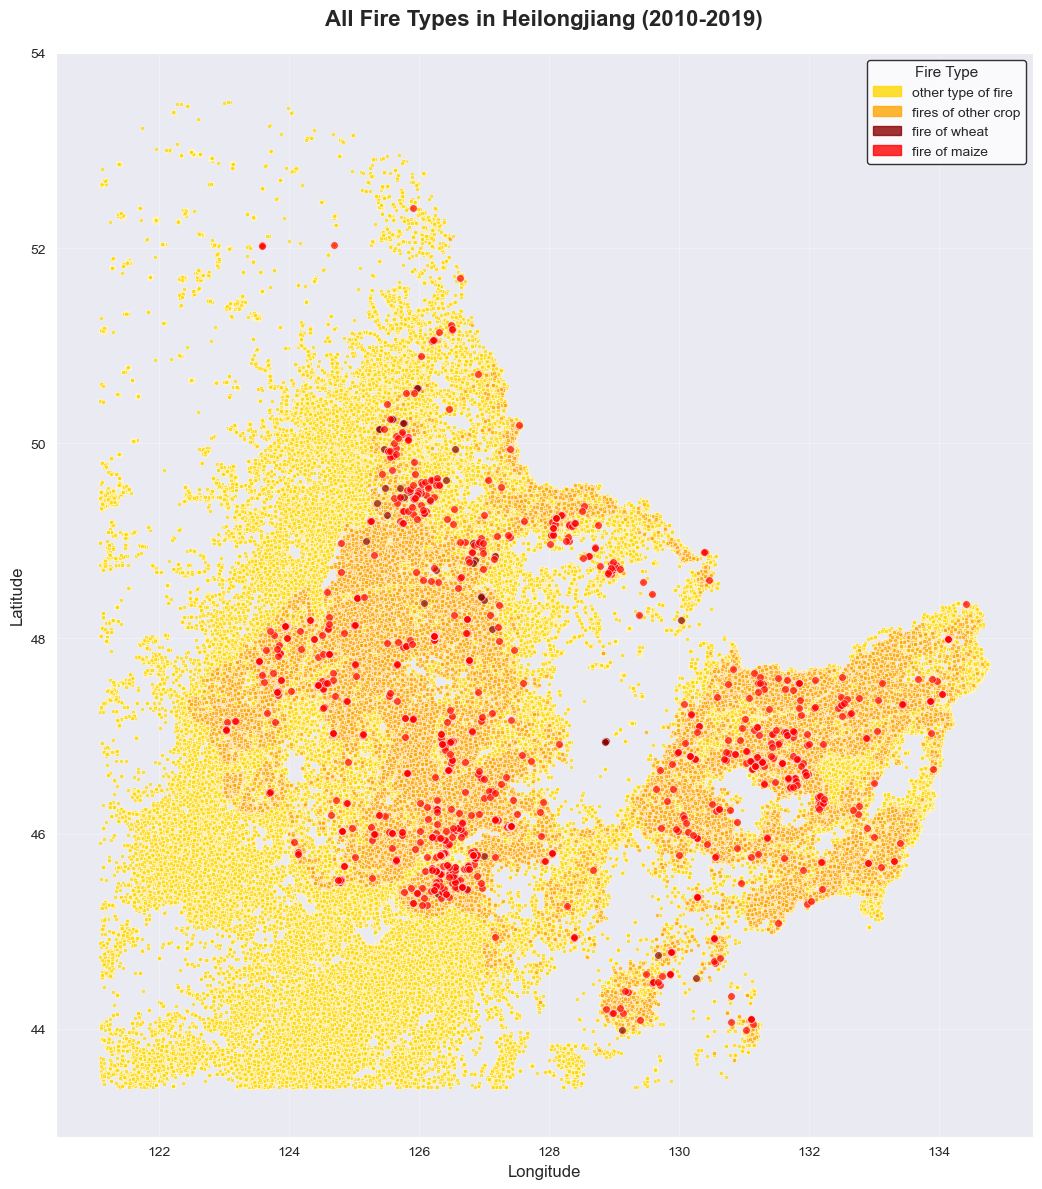

OKKKKKKK!


In [39]:
fire_type_map = fire_type_map(fire_gdf)

In [33]:
def agri_burning(fire_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    agricultural_fires = fire_gdf[fire_gdf['fire_type'].isin(['fire of maize', 'fire of wheat', 'fires of other crop'])]

    if len(agricultural_fires) > 0:
        color_map = {
            'fire of maize': '#FF0000',
            'fire of wheat': '#FF4500',
            'fires of other crop': '#F08080'
        }

        size_map = {
            'fire of maize': 20,
            'fire of wheat': 20,
            'fires of other crop': 10
        }

        legend_handles = []

        draw_order = ['fires of other crop', 'fire of wheat', 'fire of maize']

        for fire_type in draw_order:
            if fire_type in color_map:
                color = color_map[fire_type]
                marker_size = size_map[fire_type]
                subset = agricultural_fires[agricultural_fires['fire_type'] == fire_type]
                if len(subset) > 0:
                    subset.plot(ax=ax, color=color, markersize=marker_size, alpha=0.7,
                               edgecolor='white', linewidth=0.8, label=fire_type)
                    legend_handles.append(mpatches.Patch(color=color, label=fire_type, alpha=0.8))

        if legend_handles:
            ax.legend(handles=legend_handles, title='Fire Type',
                     frameon=True, facecolor='white', edgecolor='black',
                     fontsize=11, title_fontsize=12, loc='upper right')

    else:
        ax.text(0.5, 0.5, 'No agricultural fire data',
               ha='center', va='center', transform=ax.transAxes, fontsize=14)

    ax.set_title('Distribution of Agricultural Burning in Heilongjiang (2010-2019)',
                fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    total_fires = len(fire_gdf)
    agri_fires = len(agricultural_fires)
    if total_fires > 0:
        percentage = (agri_fires / total_fires) * 100
        stats_text = f"Agricultural burning: {agri_fires:,} fires ({percentage:.1f}% of total)"
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
               verticalalignment='top')

    plt.tight_layout()
    plt.savefig('agricultural_burning_distribution_2order.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

    print("Save!!!!!!")
    return fig


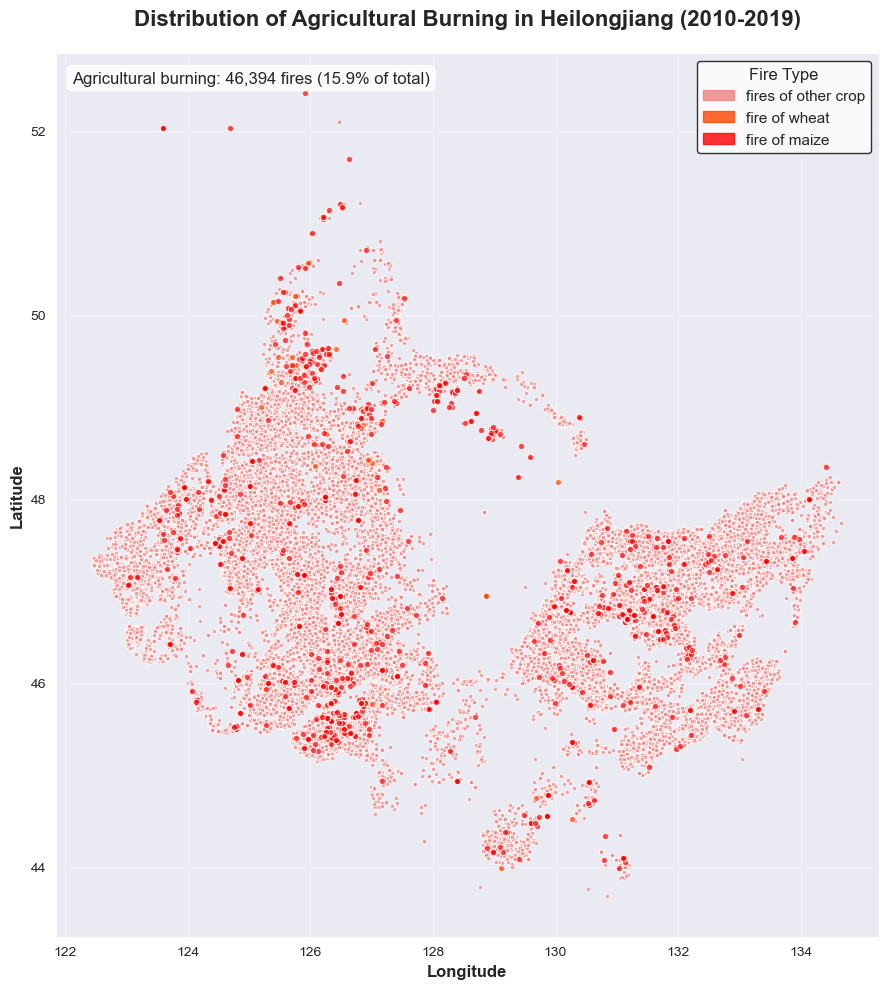

Save!!!!!!


In [34]:
agri_map = agri_burning(fire_gdf)

In [61]:
def density(fire_gdf):

    grid_size = 0.2
    fire_gdf['grid_lat'] = (fire_gdf['latitude'] / grid_size).astype(int) * grid_size
    fire_gdf['grid_lon'] = (fire_gdf['longitude'] / grid_size).astype(int) * grid_size

    grid_density = fire_gdf.groupby(['grid_lat', 'grid_lon']).size().reset_index(name='total_density')

    geometry = [Point(lon, lat) for lon, lat in zip(grid_density['grid_lon'], grid_density['grid_lat'])]
    density_gdf = gpd.GeoDataFrame(grid_density, geometry=geometry, crs="EPSG:4326")

    from matplotlib.colors import LinearSegmentedColormap

    colors_red = [
        '#FFCCCC',
        '#FF9999',
        '#FF6666',
        '#FF3333',
        '#FF0000',
        '#CC0000',
        '#990000'
    ]
    red_solid_cmap = LinearSegmentedColormap.from_list('red_solid', colors_red, N=256)

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    vmax_total = max(density_gdf['total_density'].max(), 1)

    density_gdf.plot(column='total_density', ax=ax,
                    cmap=red_solid_cmap, legend=True,
                    markersize=35, alpha=1.0,
                    vmin=0, vmax=vmax_total,
                    edgecolor='#660000', linewidth=0.5)

    ax.set_title('Total Fire Point Spatial Density', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.grid(True, alpha=0.2, linestyle='--')
    ax.set_facecolor('#f8f9fa')

    plt.tight_layout()

    plt.savefig('density_map.png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.show()

    print("SAVE!!!!!!!!!")

    return density_gdf


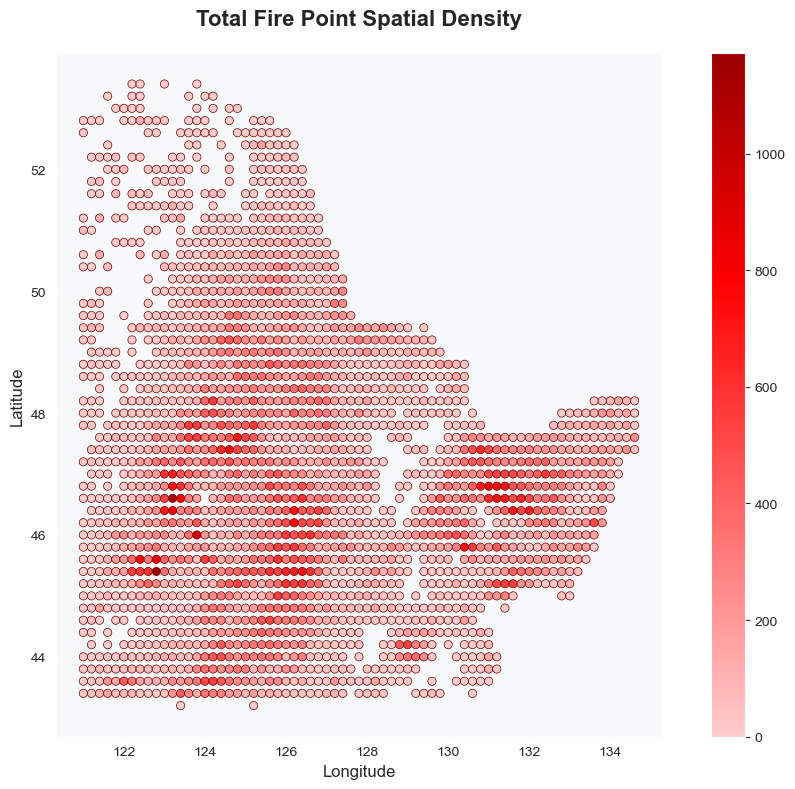

SAVE!!!!!!!!!


In [62]:
density_png = density(fire_gdf)

In [35]:
def seasonal_dist(gdf):
    if 'month' not in gdf.columns:
        gdf['month'] = gdf['acq_date'].dt.month

    monthly_stats = pd.crosstab(gdf['month'], gdf['fire_type'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    color_map = {
        'spring fire of maize': '#E31A1C',
        'autumn fire of maize': '#FD8D3C',
        'spring fire of wheat': '#A50F15',
        'autumn fire of wheat': '#FE9929',
        'maize field fire (non-seasonal)': '#D9D9D9',
        'wheat field fire (non-seasonal)': '#F0F0F0',
        'other type of fire': '#FFFFBF'
    }

    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    monthly_stats.plot(kind='bar', stacked=True, ax=ax1,
                      color=[color_map.get(col, '#969696') for col in monthly_stats.columns])

    ax1.set_title('Monthly Distribution of Hotspot Types (Full View)',
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Hotspots', fontsize=12)
    ax1.set_xlabel('Month', fontsize=12)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Fire Type')
    ax1.set_xticklabels([month_names[i-1] if i <= len(month_names) else str(i)
                       for i in monthly_stats.index], rotation=0)

    significant_stats = monthly_stats.drop(columns=['other type of fire'], errors='ignore')
    if not significant_stats.empty:
        significant_stats.plot(kind='bar', stacked=True, ax=ax2,
                             color=[color_map.get(col, '#969696') for col in significant_stats.columns])

        ax2.set_title('Monthly Distribution (Excluding "Other Type of Fire") - Detailed View',
                     fontsize=14, fontweight='bold')
        ax2.set_ylabel('Number of Hotspots', fontsize=12)
        ax2.set_xlabel('Month', fontsize=12)
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Fire Type')
        ax2.set_xticklabels([month_names[i-1] if i <= len(month_names) else str(i)
                       for i in monthly_stats.index], rotation=0)

    plt.tight_layout()
    plt.show()

    spring_fires = gdf[gdf['month'].isin([3, 4])]
    autumn_fires = gdf[gdf['month'].isin([10, 11])]
    other_fires = gdf[~gdf['month'].isin([3, 4, 10, 11])]

    total_count = len(gdf)

    print("seasonal:")
    print("=" * 50)
    print(f"spring (3-4月): {len(spring_fires):,} ({len(spring_fires)/total_count*100:.2f}%)")
    print(f"autumn (10-11月): {len(autumn_fires):,} ({len(autumn_fires)/total_count*100:.2f}%)")
    print(f"other month: {len(other_fires):,} ({len(other_fires)/total_count*100:.2f}%)")
    print("=" * 50)
    print(f"total: {total_count:,}")

    return monthly_stats

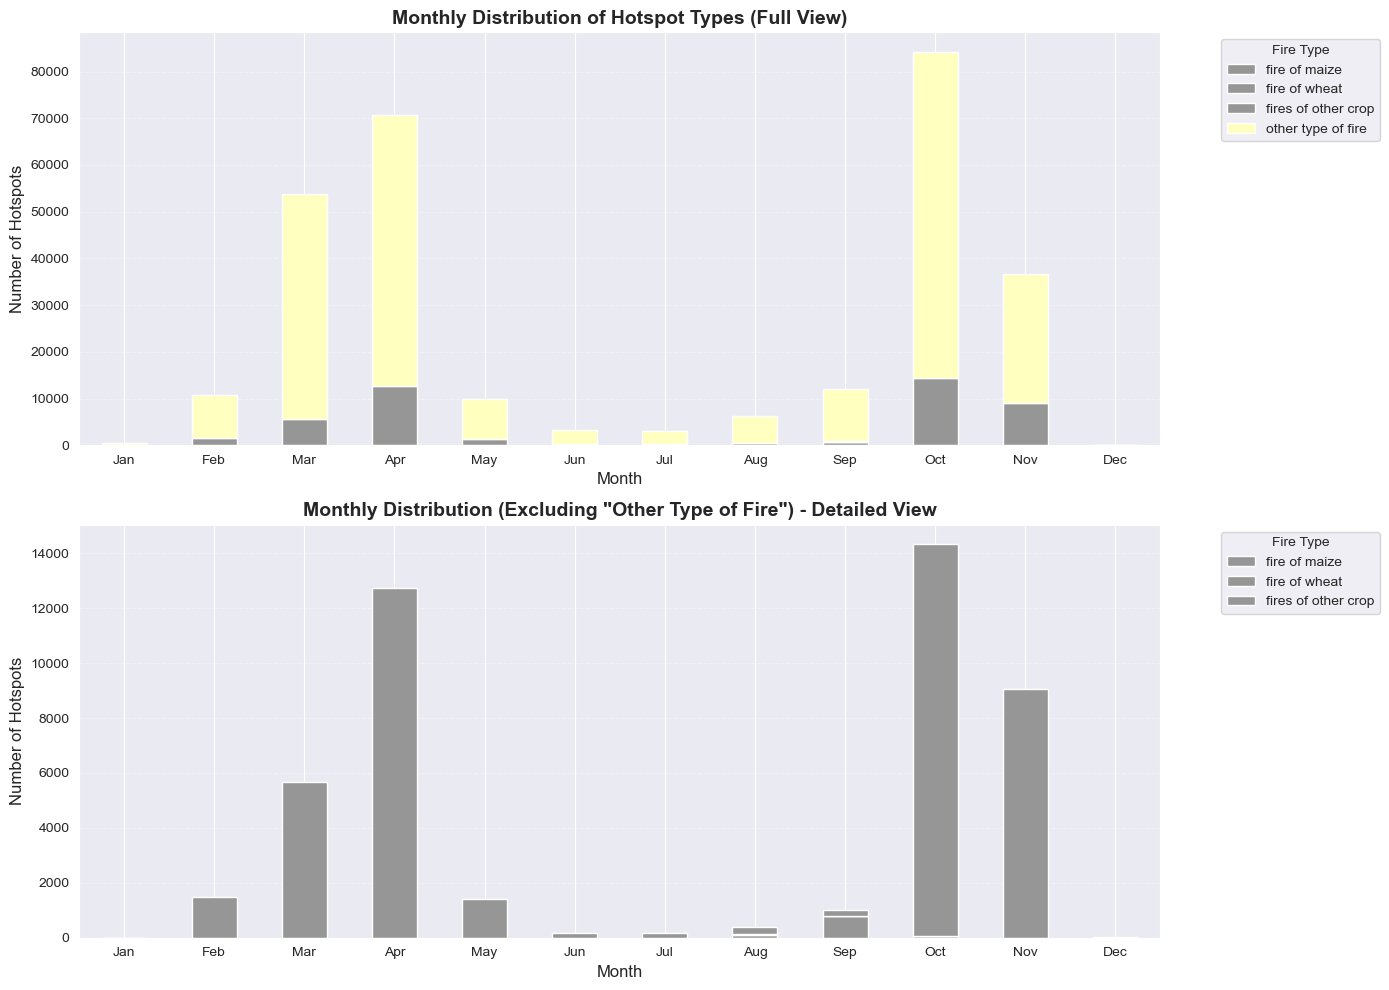

seasonal:
spring (3-4月): 124,436 (42.77%)
autumn (10-11月): 120,805 (41.53%)
other month: 45,673 (15.70%)
total: 290,914


In [36]:
seasonal = seasonal_distribution(fire_gdf)